# Task 4: Fraud Detection in Financial Transactions

## Task Overview

Objective: Identify fraudulent transactions from synthetic financial data.

Deliverables:

• Data preprocessing and visualization\
• Class balancing (SMOTE or undersampling)\
• Random Forest / Gradient Boosting model\
• Confusion matrix, Precision/Recall analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [ ]:
n = 50000
data = pd.DataFrame({
    'TransactionID': np.arange(n),
    'Amount': np.round(np.random.exponential(scale=100, size=n), 2),
    'Time': np.random.randint(0, 86400, size=n),  # seconds in a day
    'Location': np.random.choice(['NY', 'CA', 'TX', 'FL'], size=n),
    'Device': np.random.choice(['Mobile', 'Web', 'ATM'], size=n),
    'IsFraud': np.random.choice([0, 1], size=n, p=[0.98, 0.02])
})

In [103]:
data.sample(5)

,TransactionID,Amount,Time,Location,Device,IsFraud
5548,5548,229.46,19688,FL,Mobile,0
37543,37543,12.16,24901,TX,Web,0
22735,22735,143.40,16649,TX,Mobile,0
3494,3494,59.95,61208,NY,ATM,0
42802,42802,294.04,83431,TX,Web,0


In [104]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TransactionID  50000 non-null  int64  
 1   Amount         50000 non-null  float64
 2   Time           50000 non-null  int64  
 3   Location       50000 non-null  object 
 4   Device         50000 non-null  object 
 5   IsFraud        50000 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 2.3+ MB


In [105]:
data.describe()

,TransactionID,Amount,Time,IsFraud
count,50000.000000,50000.000000,50000.000000,50000.000000
mean,24999.500000,100.478261,43233.109520,0.018500
std,14433.901067,100.564985,24910.786162,0.134752
min,0.000000,0.000000,0.000000,0.000000
25%,12499.750000,29.305000,21647.750000,0.000000
50%,24999.500000,70.280000,43265.500000,0.000000
75%,37499.250000,138.110000,64926.250000,0.000000
max,49999.000000,1043.960000,86399.000000,1.000000


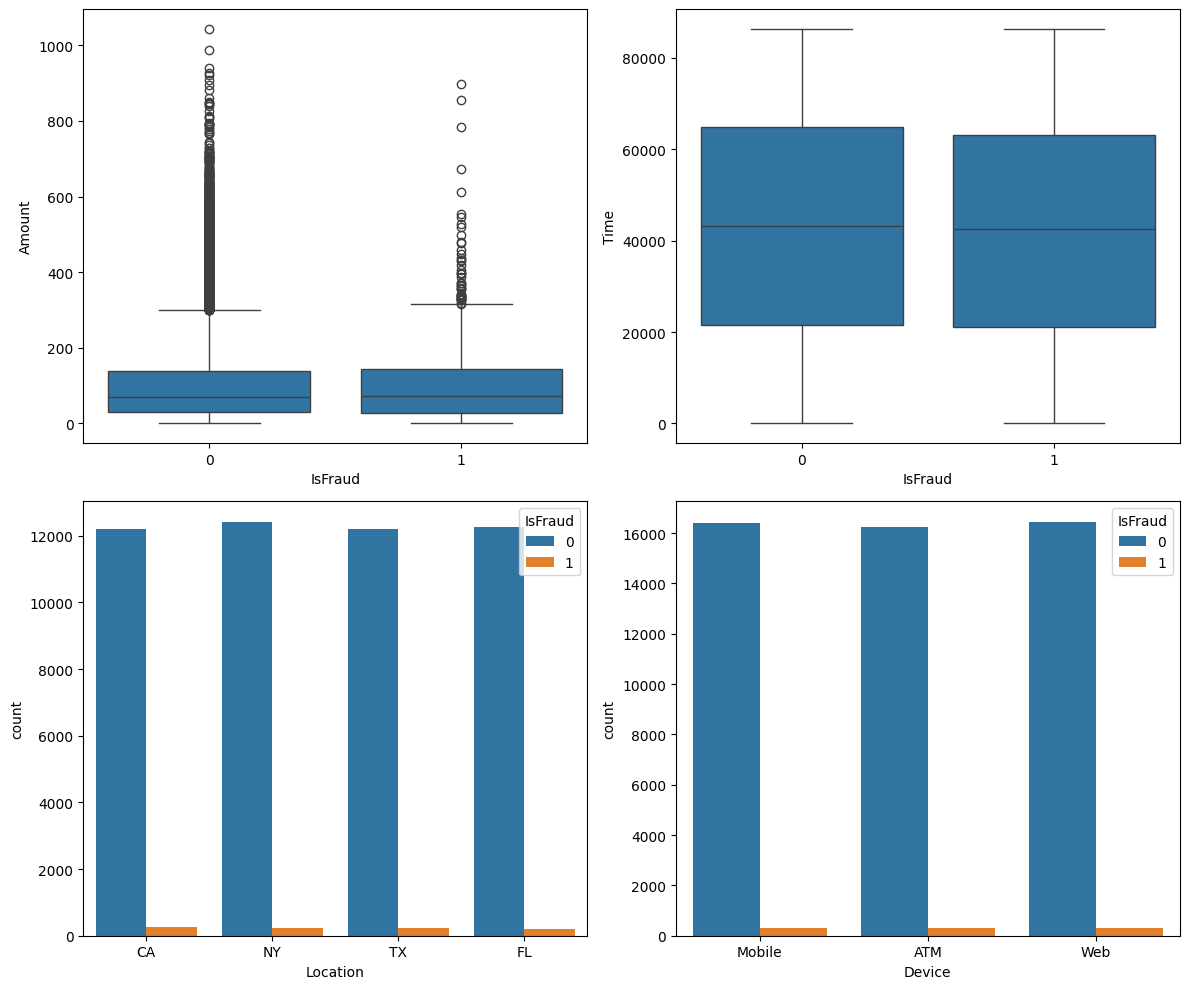

In [106]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
sns.boxplot(x='IsFraud', y='Amount', data=data, ax=axs[0, 0])
sns.boxplot(x='IsFraud', y='Time', data=data, ax=axs[0, 1])
sns.countplot(x='Location', hue='IsFraud', data=data, ax=axs[1, 0])
sns.countplot(x='Device', hue='IsFraud', data=data, ax=axs[1, 1])
plt.tight_layout()
plt.show()

In [107]:
data.columns

Index(['TransactionID', 'Amount', 'Time', 'Location', 'Device', 'IsFraud'], dtype='object')

In [108]:
X = data[['Amount', 'Time', 'Location', 'Device']]
y = data['IsFraud']

In [109]:
print("Original class distribution:")
print(data['IsFraud'].value_counts())

Original class distribution:
IsFraud
0    49075
1      925
Name: count, dtype: int64


In [112]:
# Preprocess data
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

le = LabelEncoder()
X.loc[:, 'Location'] = le.fit_transform(X['Location'])
X.loc[:, 'Device'] = le.fit_transform(X['Device'])

# preprocess the data
scalar = MinMaxScaler()
X.loc[:, ['Amount', 'Time']] = scalar.fit_transform(X[['Amount', 'Time']])


/tmp/ipykernel_514198/2501154083.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.88507969 0.94760356 0.444982   ... 0.7705992  0.69556361 0.48238984]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[:, ['Amount', 'Time']] = scalar.fit_transform(X[['Amount', 'Time']])


In [113]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [114]:
# --- Balancing with SMOTE + Undersampling ---
over = SMOTE(sampling_strategy=0.1, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)

balancing_pipeline = Pipeline(steps=[
    ('smote', over),
    ('under', under)
])

In [115]:
# Apply balancing
X_train_res, y_train_res = balancing_pipeline.fit_resample(X_train, y_train)

In [116]:
len(X_train_res), y_train_res.value_counts()

(11778,
 IsFraud
 0    7852
 1    3926
 Name: count, dtype: int64)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42, 
                                  n_estimators=100, 
                                #   min_samples_leaf=0.05
                                  ) 
model.fit(X_train_res, y_train_res)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [118]:
y_pred = model.predict(X_test)

In [119]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#evaluate the model
print('accuracy score: ', accuracy_score(y_test, y_pred))
print('confusion matrix:\n', confusion_matrix(y_test, y_pred))
print('classification report:\n', classification_report(y_test, y_pred))

accuracy score:  0.8498
confusion matrix:
 [[8477 1338]
 [ 164   21]]
classification report:
               precision    recall  f1-score   support

           0       0.98      0.86      0.92      9815
           1       0.02      0.11      0.03       185

    accuracy                           0.85     10000
   macro avg       0.50      0.49      0.47     10000
weighted avg       0.96      0.85      0.90     10000



## REPORT:

The model is evaluated on a dataset of 10000 samples. The results are as follows:

- Our model is predicting 85% accurately.
- The model performs well on `Class 0`, achieving high recall (0.86), meaning it correctly identifies most of the `Class 0` samples.
- For `Class 1`, performance is poor, with recall only 0.11. This shows the model is failing to detect most of `Class 1` cases.

The model is biased toward `Class 0` and struggles with detecting `Class 1`